In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = '../PyTorchDiaries/Temp/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [5]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [6]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

In [7]:
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [8]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

In [9]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [10]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [13]:
conv = nn.Conv2d(3, 16, kernel_size = 3) # can pass (3,3) instead of 3 for conv_size
# 3 input features per pixel RGB
# Arbitrary channels in output say, 16

conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [14]:
conv.weight.shape, conv.bias.shape
# Kernel size (3*3) * input_channel(3) * output_channel(16)

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [15]:
# Conv expects a B*C*H*W as input, adding a batch dimension
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

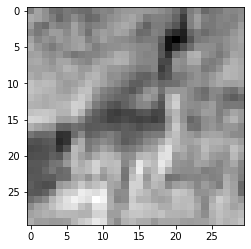

In [16]:
plt.imshow(output[0,0].detach(), cmap="gray")
plt.show()

In [17]:
conv = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

In [18]:
# Sizes of weight and bias dont change regardless of padding 
# Padding helps us seprate the matters of convolutions and changing image sizes (one less thing to remember)
# When using more complex structures like skip connections or U-Nets , we want
# Tensor after a few convolutions to be of same size so we can add them or take difference

### Detecting features with convolutions 

In [19]:
# Setting bias to zero and weights manually to take average of surrounding pixels
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

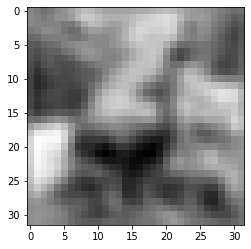

In [21]:
# Checking its effect on the image
output = conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach(), cmap="gray")
plt.show()

In [23]:
# A simple edge detecting kernel
conv = nn.Conv2d(3, 1, kernel_size = 3, padding = 1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                  [-1.0, 0.0, 1.0],
                                  [-1.0, 0.0, 1.0],])
    conv.bias.zero_()

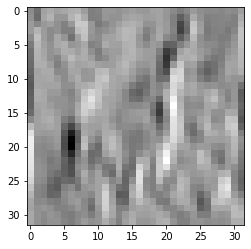

In [24]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach(), cmap="gray")
plt.show()

### Pooling 

In [25]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [26]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... <1>
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [27]:
model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

In [28]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size = 3, padding = 1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8*8*8) # The dimensionality change missing from nn.Sequential
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [29]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]

sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [35]:
# Functional API
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out = out.view(-1, 8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [36]:
model = Net()
model(img.unsqueeze(0))

tensor([[ 0.2028, -0.0486]], grad_fn=<AddmmBackward>)

In [45]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        
        for imgs, labels in train_loader:
            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch %10 == 0:
            print("{} Epoch {},  Training Loss {}".format(
            datetime.datetime.now(),
            epoch,
            loss_train/len(train_loader))) # Average loss per batch

In [46]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss() # No need of softmax and NLL, can use this directly

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2021-01-03 19:06:55.526571 Epoch 1,  Training Loss 0.5663619339466095
2021-01-03 19:07:27.337687 Epoch 10,  Training Loss 0.33277240091828025
2021-01-03 19:08:06.934222 Epoch 20,  Training Loss 0.2922037091984111
2021-01-03 19:08:56.530603 Epoch 30,  Training Loss 0.27029731879188756
2021-01-03 19:09:56.029306 Epoch 40,  Training Loss 0.2490790551824934
2021-01-03 19:10:52.476425 Epoch 50,  Training Loss 0.2318013100677235
2021-01-03 19:11:51.539510 Epoch 60,  Training Loss 0.21851801506842777
2021-01-03 19:12:48.175785 Epoch 70,  Training Loss 0.20073316213051984
2021-01-03 19:13:44.523474 Epoch 80,  Training Loss 0.18765443549224525
2021-01-03 19:14:45.418474 Epoch 90,  Training Loss 0.17322497342707247
2021-01-03 19:15:44.329086 Epoch 100,  Training Loss 0.1604333293808114


In [47]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle = False)

val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size = 64, shuffle = False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train",train_loader), ("val",val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
                
        print("Accuracy : {}: {:.2f}".format(name, correct/total))
        
        
validate(model, train_loader, val_loader)

Accuracy : train: 0.91
Accuracy : val: 0.87


### Saving Models

In [48]:
torch.save(model.state_dict(), data_path + "birds_vs_plane.pt")

In [49]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + "birds_vs_plane.pt"))

<All keys matched successfully>